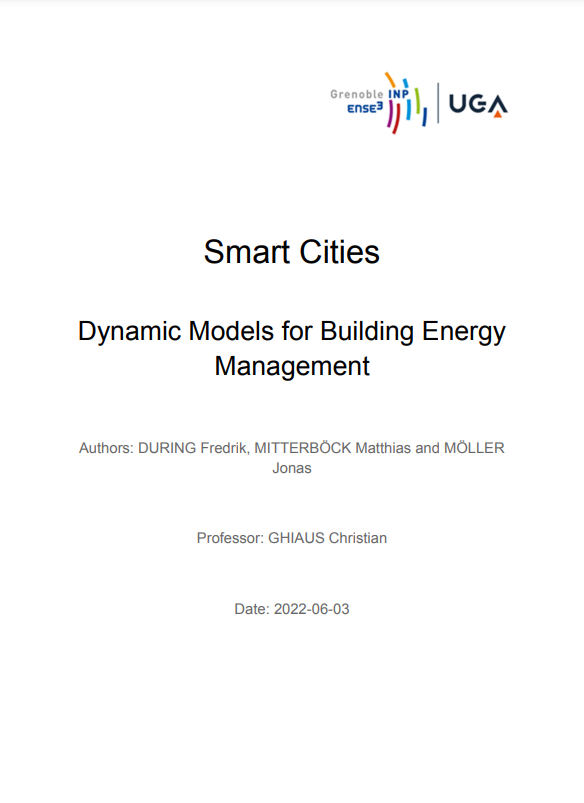

## Table of content
1. Introduction
2. Hypothesis
3. Building plan
4. Thermal model
5. Implementation
6. Results
7. Conclusion



## 1. Introduction
In France, the energy consumption in the building sector amounts to 44 % of the final energy consumption, ahead of the transport sector and the industry as second and third highest consumer, respectively [1]. At the same time, saving energy by
means of an improved insulation or intelligent heating and cooling systems can be very effective. To allow for a realistic estimate of the possibilities for better energy management without extensive in-situ measurement, system models and simulations of the investigated buildings or - on a smaller scale – mere rooms, are applied. 
In this work, a typical room in a student residence is investigated. The room is modelled with the adjacent outer and inner walls a separate bathroom and electrical appliances. Furthermore, weather data is implemented, leading to changing outside boundary conditions.
The results are expected to showcase the behaviour of the indoor temperature in relation to the outside temperature and the running appliances and heating and cooling systems.

[1] https://www.ecologie.gouv.fr/energie-dans-batiments#:~:text=Le%20secteur%20du%20b%C3%A2timent%20repr%C3%A9sente,climatique%20et%20la%20transition%20%C3%A9nerg%C3%A9tique.v


## 2. Hypothesis
In order to construct a simplified model of the room the following prelimiary assumptions were made:
- Homogenous surface temperature distribution on the walls
- The heat transfer in the walls is one-dimensional
- Equaly spread solar radiation
- The LW radiation exchange is not considered.
- All heat transfer treated as if linear.

## 3. Building plan

The room spans 5 by 4 meters is 2,4m high and contains a smaller 2m by 2m bathroom. The two rooms are connected through a wooden door. The main
room is also connected to the hallway with the same type of door. The bordering room as well as the rooms above and below the appartment are neglected
as they are assumed to have the exact same room temperature as the modeled room. 
The outside wall is modeled as a 30cm concrete wall with an 15cm thick layer of insolation
on the inside of the room. The chosen insolation material has a heat conductivity of 0,04W/mK, which corresponds
to a very good insulation material. All the concrete was modeled with a conductivity of 1.4W/mK. The window in the outside wall is 1m wide and 1,4m high. 
The walls between the main room and the bathroom as well as the wall to the hallway were chosen to be 10cm thick and made out of concrete.
The electronic appliences in the room summed up in the picture as only a refrigerator and the electronic towel dryer are the only sources of heat in the
room appart from the Heating Ventilation Air Contitioning (HVAC) system.

The geometry of the model follows the figure below. This geometry was used to represent a Crous recidance in Maison de Étudiants.

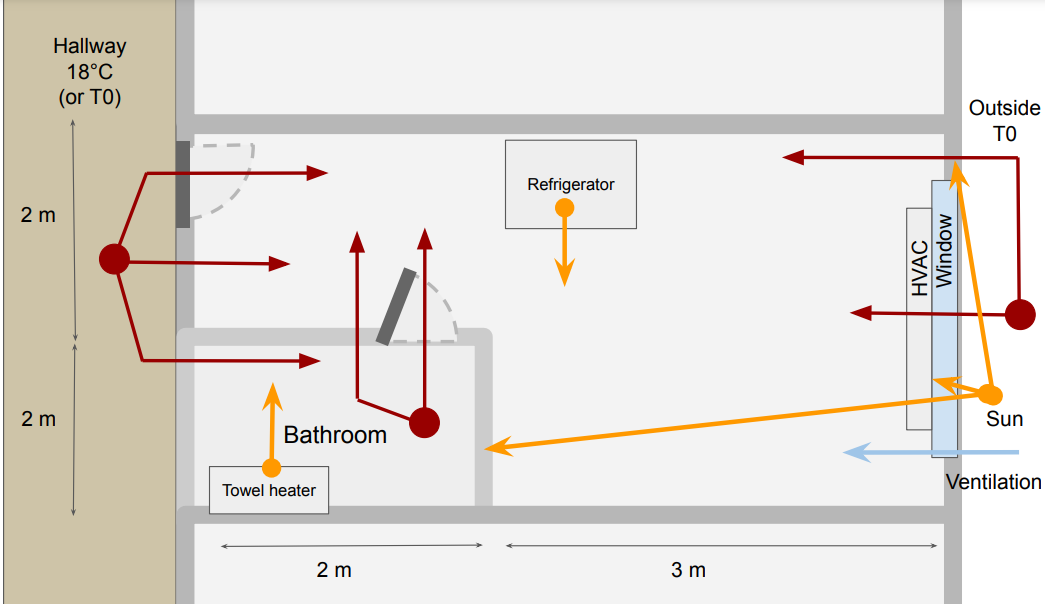

This geometry was transformed in to a shematic shown in the figure below.

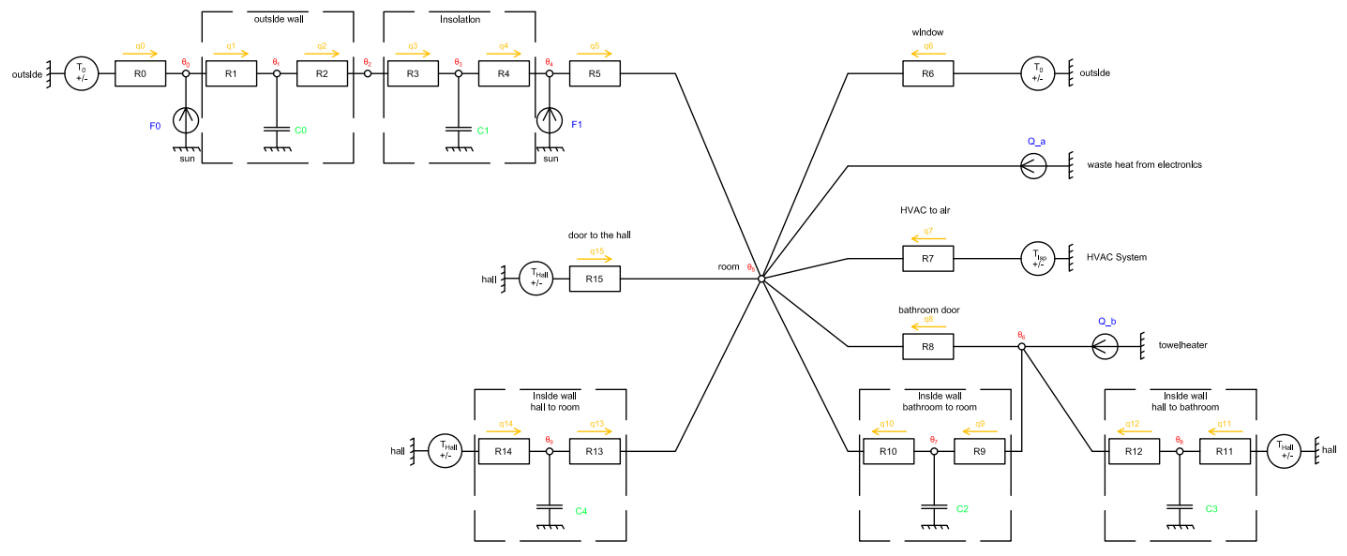


## 4.Thermal model
The figure below shows the thermal model used to describe the network. The A matrix reprecents the relationshipps between the temperature nodes θ in regards to the direction of the flow q. The following vectors contain the things listed below.

**b-vector describes the temperature sources and contains:**		
- T0 - Outside temp.	
- T_isp - Indoor temp. setpoint / radiator	
- T_hall - Hall temp.	

**f-vecor describes the external flows sourses.**			
- F0 - Sunlight on the outside walll		
- F1 - Sunlight on the inside walll		
- Q_a - Internal heat sources		
- Q_b - Bathroom heat sources		

**C-vector describes the capacities inside maretials**			
- C0 - C_ins		
- C1 - C_wall		
- C2 - C_bathroom_to_room		
- C3 - C_Hall_bathroom		
- C4 - C_Hall_room		


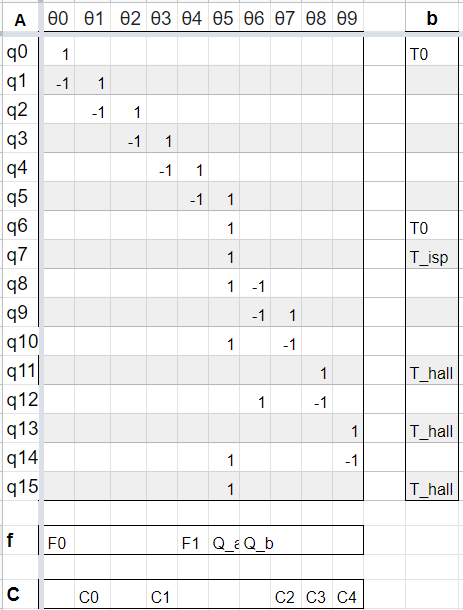




## 5. Implementation

Importing nessecary data packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

We introduce a perfect controller Kp=1e4 and a value for Kp that is almost zero to remove the controller Kp=1e-3.

In [15]:
#-------  Physical values  ------------------------------------------------
# P-controler gain
#Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0

In [16]:
# -------  Geometry ----------------- 

H = 2.4           # m height of the rooms

#Bath room
l_b = 2           #  m length of the bathoom
w_b = 2           #  m width of the bathoom

#Main room
l = 5             #  m length of the main room
w = 4             #  m width of the main room 

Va = l * w * H           # m³ volume of air in the room
ACH = 1                     # air changes per hour
Va_dot = ACH * Va / 3600    # m³/s air infiltration

#Window
h_w = 1.4         # m height of window
b_w = 1           # m width of window

#Doors
h_d = 2         # m height of door
b_d = 1         # m width of door

# Surface areas [m^2]
Sw = h_w * b_w                      #Surface area window
Sd = h_d * b_d                      #Surface area door
Swallouter =  w * H - Sw            #Surface area outer wall minus window
Swallroombath = l_b * w_b * H - Sd  #Surface room to bath minus door
Swallhallbath = (w - w_b) * H       #Surface hall to bath
Swallroomhall = (w - w_b) * H - Sd  #Surface hall to room minus door


The properties for the room were reserched on the internet. The following materials were used and inplemented into the wall dataframe. The U-value for the window and the doors were taken from manufacturer data and added to the wall dataframe.

In [17]:
# -------  Thermophyscal properties  ------------------------------------------

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1006}               # J/kg.K

wall = {'Conductivity': [1.4, 1.4, 1.4, 1.4, 0.04],      # W/m.K
        'Density': [2500, 2500, 2500, 2500, 30],            # kg/m³
        'Specific heat': [880, 880, 880, 880, 920],      # J/kg.K
        'Width': [0.3, 0.1, 0.1, 0.1, 0.15],        #Glass is still there but not used
        'Surface': [Swallouter, Swallroombath, Swallhallbath, Swallroomhall, Swallouter],
        'Slice': [4, 2, 2, 2, 2]}                    # in how many parts does the material get segmented in to

wall = pd.DataFrame(wall, index=['Wallouter', 'Wallroombath', 'Wallhallbath','Wallroomhall', 'Insulation'])


For simplification the model only takes in to account the absortivity of the inside wall (white) and the short wave transmitted through the window hitting th wall.

In [18]:
#------- Radiative properties -------------------------------------------------
""" grey to dark surface EngToolbox, Absorbed Solar Radiation by Surface Color """
α_wSW = 0.2     # absortivity white surface

""" EngToolbox Optical properties of some typical glazing mat Window glass """
τ_gSW = 0.83    # short wave glass transmitance

h = pd.DataFrame([{'in': 4, 'out': 10}]) #indoor and outdoor

The thermal resistances was determaind by using the constitituve laws for conduction and convection in conjuction with the data for the different materials in the wall dataframe. The U-values were implemented as well.

The capacity was calculated taking in to account the volume of air in the room aand the walls with their respective specific heats.

In [19]:
#------- Thermal circuit -------------------------------------------------
# Thermal conductances

# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']

# Convection
G_cv = {'in': [], 'out': []}
for i in wall['Surface']:
    G_cv['in'].append(i * h['in'][0])
    G_cv['out'].append(i * h['out'][0])
G_cv = pd.DataFrame(G_cv, index = ['Wallouter', 'Wallroombath', 'Wallhallbath','Wallroomhall', 'Insulation'])

#Window combined value U-Value [W/m²]
G_win = 1

#Door combinded value U-Value [W/m²] 
G_door = 1.5

# Thermal capacities
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C['Air'] = air['Density'] * air['Specific heat'] * Va

The thermal resistors was added in to a matrix G. The capacitors was then added in to the diagonal of a matrix C.

In [20]:
#----------------------    End of our MATRIX     -----------------------------
# note: just add values in this  vector!

G = np.diag([
        G_cv['out']['Wallouter'], 
        2 * G_cd['Wallouter'], 
        2 * G_cd['Wallouter'],
        2 * G_cd['Insulation'],
        2 * G_cd['Insulation'],
        G_cv['in']['Wallouter'],
        G_win, 
        Kp, 
        G_door, 
        G_cv['in']['Wallroombath'] + 2 * G_cd['Wallroombath'],
        2 * G_cd['Wallroombath'] + G_cv['in']['Wallroombath'],
        G_cv['in']['Wallhallbath'] + 2 * G_cd['Wallhallbath'], 
        2 * G_cd['Wallhallbath'] + G_cv['in']['Wallhallbath'],   
        G_cv['in']['Wallroomhall'] + 2 * G_cd['Wallroomhall'],   
        2 * G_cd['Wallroomhall'] + G_cv['in']['Wallroomhall'],      
        G_door, 
        ])

C = np.diag([0, C['Wallouter'], 0, C['Insulation'], 0, 0, 0, C['Wallroombath'], C['Wallhallbath'], C['Wallroomhall']])

To represent schematic of the model and connect the flows and nodes to one another the A matrix was defimed. 

In [21]:
#----------------------    our MATRIX / our code     -------------------------
# Incidence matrix
A = np.zeros([16, 10]) #create an matrix with zeros
# adds values for the ones /= 0
A[0, 0] = 1 
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 5] = 1
A[7, 5] = 1
A[8, 5], A[8, 6] = 1,-1
A[9, 6], A[9, 7] = -1, 1
A[10, 5], A[10, 7]  = 1, -1
A[11, 8] = 1
A[12, 6], A[12, 8]  = 1, -1
A[13, 9] = 1
A[14, 5], A[14, 9]  = 1, -1
A[15, 5] = 1

The temperatures in the model were added in to a b-vector and the flow sources were added in to a f-vector. For the temperature matix we set our outside temperature to 10, the setpoint to 20 and the hallway temperature to 18 degrees. 
The flow source vector we assumed somewhat realistic values for our flow sources. The sun was set at 1000 Watts on the outside of the wall, 500 Watts passing through the window heating the interiour wall, 500 Watts of waste heat from electronic devices such as the refrigorator and 500 Watts form the Towel heater in the bathroom.

In [22]:
#------- More written MATRIXES -----------------------------------------------

#b = np.array([T0, 0, 0, 0, 0, 0, T0, T_isp, 0, 0, 0, T_hall, 0, T_hall, 0, T_hall])
b = np.zeros(16)
b[[0, 6, 7, 11, 14, 15]] = 273.15 + np.array([10, 10, 20, 18, 18, 18])
    
    
#f = np.array([F0, 0, 0, 0, F1, Q_a, Q_b, 0, 0, 0])
f = np.zeros(10)
f[[0, 4, 5, 6]] = np.array([1000, 500, 500, 500]) # just random values for now

y = np.ones(10)

u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

These matrixes were transformed into a state space model by utilising the dm4bem.tc2ss tool provided. The returend error from this operation was negligible.

In [23]:
# Thermal circuit -> state-space
# ==============================
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

# Test: comparison steady-state of thermal circuit and state-space
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

[295.908 296.512 297.115 307.677 318.239 304.404 301.813 303.108 296.481
   6.627]
[295.908 296.512 297.115 307.677 318.239 304.404 301.813 303.108 296.481
   6.627]
Max error in steady-state between thermal circuit and state-space: 3.98e-13


For the dynamic model we redifine our b and f matrixes. We retransform them to state space and calculate a maximum time step to ensure we choose a high enough resolution in our dynamic simulation. Here we set the timestep to 360 seconds.

In [24]:
# Dynamic simulation
# ==================
# Thermal circuit -> state-space with 1 for b, f, y
b = np.zeros(16)
b[[0, 6, 7, 11, 14, 15]] = 1

f = np.zeros(10)
f[[0, 4, 5, 6]] = 1

y = np.zeros(10)
y[[5]] = 1

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

# Maximum time-step
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')
dt = 360
print(f'Time step: {dt:.2f} s')

Maximum time step: 6875.00 s
Time step: 360.00 s


We implement a standard step response to make sure our simulation works in steady state. 

[Text(0, 0.5, '$T_i$ [°C]'), Text(0.5, 1.0, 'Step input: To = 1°C')]

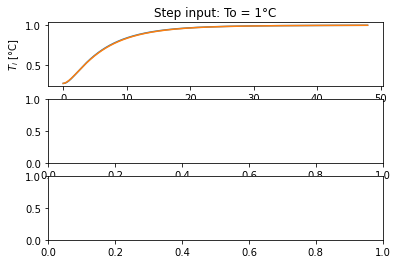

In [25]:
# Step response
# -------------
duration = 3600 * 24 * 2       # [s]
# number of steps
n = int(np.floor(duration / dt))

t = np.arange(0, n * dt, dt)    # time

# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To Tsp Phio Phii Qaux Phia]
# u = [T0, T0, T_sp, T_hall, T_hall, T_hall, f_out, f_wall, f_elect, f_towel]

u = np.zeros([10, n])
u[0:2, :] = np.ones([2, n])
u[3:6, :] = np.ones([3, n])
#fill the matrix with the changing T0, and t Hall

#u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

# initial values for temperatures obtained by explicit and implicit Euler
temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, axs = plt.subplots(3, 1)
axs[0].plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
axs[0].set(ylabel='$T_i$ [°C]', title='Step input: To = 1°C')

Next we imported the weather data. We imported 7 days form the first week of january in the year 2000, as the temperature
difference between the inside of the room and the outside should be high during that period.

The indoor set point temperature was set to 20 degrees celsius.The hall temperature was set to 18 degrees celsius initially but as this distorted the results by acting like a heat reservoir we changed the hallway temperature to the outside temperature. The appliances run at an average 300 W.


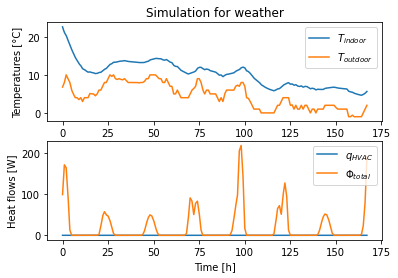

In [73]:
# Simulation with weather data
# ----------------------------
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-01-10 12:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

# Solar radiation on a tilted surface
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo) # W/m²
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)

# Interpolate weather data for time step dt
data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

# Indoor temperature set-point
data['Ti'] = 20 * np.ones(data.shape[0]) # set point inside

# Indoor auxiliary heat flow rate
data['Qa'] = 300 * np.ones(data.shape[0])

#Hall temperature
data['Thall'] = 18 * np.ones(data.shape[0]) 

# time
t = dt * np.arange(data.shape[0])

#The u matrix, the combination of our b and f matrixes should according to the modell look like this: 
#u = [T0, T0, T_sp, T_hall, T_hall, T_hall, f_out, f_wall, f_elect, f_towel]
#but as the temperature of the room always matches the temperature of the hallway we changed our conditions so that the 
#temperature in the hallway is also T0, to better show the change of the room temperature
#with the outside temperature.
u = pd.concat([data['To'], 
               data['To'], 
               data['Ti'] , 
               data['To'], 
               data['To'], 
               data['To'], 
               α_wSW * wall['Surface']['Wallouter'] * data['Φt1'], #the folowing four lines are f
               τ_gSW * α_wSW * Sw * data['Φt1'],
               data['Qa'], 
               data['Qa']], axis=1)


# initial values for temperatures
temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

# integration in time 
I = np.eye(As.shape[0])
for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

# Indoor temperature
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
# HVAC heat flow
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

# plot indoor and outdoor temperature
fig, axs = plt.subplots(2, 1)

axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')



## 6. Results
In the following chapter the rusult from the steady state and the dynamic simulations will be presented.

### 6.1 Steady state results
The two steady state restonses for the two different controllers can be seen below. 

#### 6.1.1 Steady state simulation, no controller
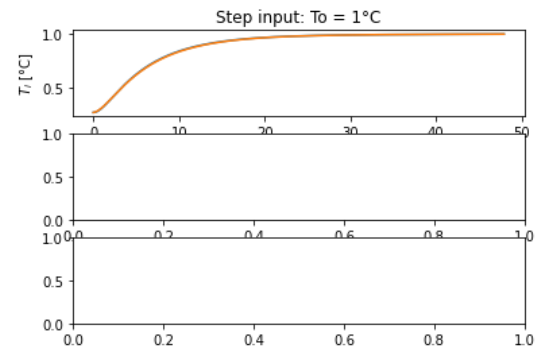
For the stepresponse with no controler (Kp=1e-3) we can obsrve that the indoor temperature follows the outside temperature. This is expected from the system and confirms that the model has the ability model this in a good way.


#### 6.1.2 Steady state simulation, perfect controller
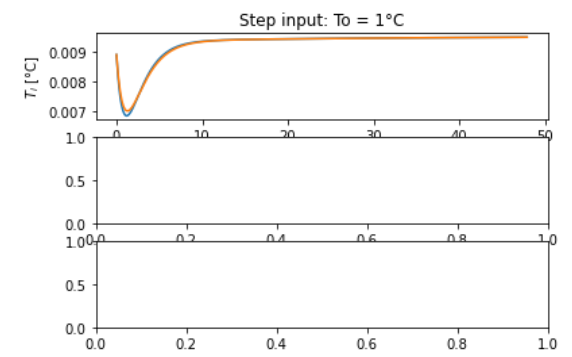

For the stepresponse with a perfect controler (Kp=1e4) we can see that something odd is happening. We would expect the indoor temperature to overshoot the outdoor temperature because of the strong gain to then stabilize at one. 
### 6.2 Dynamic results
Investigating the dynamic behaviour of the model with variable outside temperature leads to the following results. 
For this the u matrix, the combination of our b and f matrixes should according to the model look like this: 
    u = [T0, T0, T_sp, T_hall, T_hall, T_hall, f_out, f_wall, f_elect, f_towel]
but as the temperature of the room always starts to match the temperature of the hallway we changed our conditions a 
litte bit to better show the change of the room temperature with the outside temperature.

#### 6.2.2 Dynamic simulation, no controller

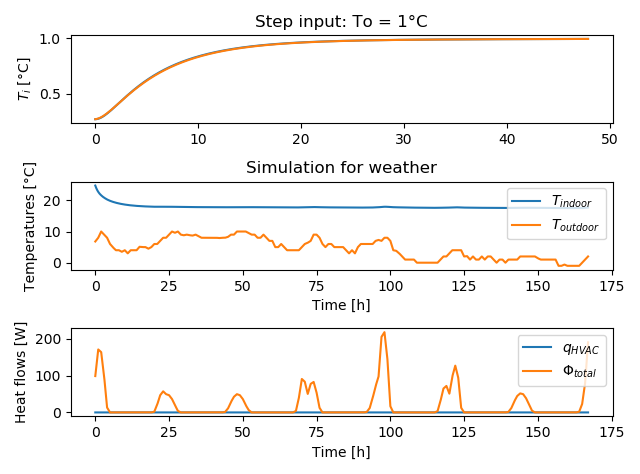

Considering no use of the HVAC (no controller, K_p -> 0), the q_HVAC remains zero and the indoor temperature closely follows the 
imposed outdoor temperature with a small delay.
The total heat flow depends on the changing outdoor temperature and the varying temperature difference between in- and 
outdoors. Following the monitored time frame the heat flow amplitude rises every day (roughly every 24 hours) with the 
sun's radiation. As shown by the implementation of a step input (first graphic in figure x) the response to a temperature 
change of 1°C leads to a fast temperature change, reaching the input temperature after about 24 hours.

#### 6.2.2 Dynamic simulation, perfect controller
The results with a perfect controller (K_p -> infinity) are shown in figure y.                      
The temperature of the room follows the setpoint temperature exactly, it always stays at 20 degrees. On the other hand in the 
the heat flow of the HVAC system directly mirrors the outdoor temperature with a small delay, while the total heat flow 
remains insignificant at around 100W.
As for the step response the spike at the beginning is due to the iterations process of the calculation
as the model is not yet adjusted.

## 7. Conclution

The model can with some accuracy follow an expected temperature fluctuation inside a room in relation to changing outdoor temperature. Results for with no controller the steady state and dynamic simulations behave as one would predict. The implementation of a controller seems to have introduced some strange behavior in the model specially for the step response. Therefore the resulting temperatures for the simulations with a perfect controller may not be as accurate. 
